---

<h1>DataScientest.com : Formation Data Scientist </h1>

---
*   **CURSUS :** Bootcamp DS, Juillet 2021
*   **PROJET 04 :**  ÉNERGIE - (MACHINE LEARNING)
*   **RAPPORT :** Exploration des données et data visualisation
*  **CHEF DE PROJET :** Mounir
*   **PARTICIPANTS :** Romain MOULY & Zéphirin NGANMENI
---



<h2> Contexte et problématique </h2>
L’énergie est une ressource incontournable pour le fonctionnement des équipements utilisés dans divers secteurs socio-économiques : santé, éclairage, chauffage, transports, agriculture, etc. Pour assurer l’équilibre entre l’offre et la demande énergétique, il faut anticiper et prévoir au quotidien, la demande énergétique qui varie au gré des phénomènes qui affectent le comportement des consommateurs. Par ailleurs, étant donné l’impact du mode de production de l’énergie sur l’environnement, on privilégie les énergies renouvelables. Ainsi, notre problématique porte sur les prévisions des évolutions de la demande et d’offre énergétiques en France en vue d’assurer la disponibilité tout en limitant les impacts environnementaux. 
Le but va être dans un premier temps de faire une étude de la situation passée et présente en terme d'adéquation de la production à la consommation et d'analyser les évolutions des sources de production utilisées. Ensuite, sur la base des données, l'objectif sera d'effectuer une modélisation permettant de prévoir les évolutions des conommations et productions électriques et de repérer potentiellement les points de tension. Egalement, une attention spéciale sera apportée à la situation des énergies renouvelables dans ce contexte.
<h2>Architecture des données</h2>
Pour aborder cette problématique, nous avons à disposition les données régionales consolidées de janvier 2013 à juin 2021 issues de l'application éCO2mix. On y trouve en méga watts les données françaises de consommation et de production électrique suivant le type de génération.
Les données de consommation et de production électrique disponibles, sont organisées suivant le type de génération (Eolien, Solaire, Hydraulique, Thermique, Nucléaire, Bioénergies ainsi que la puissance consommée par le pompage des stations de transfert d'énergie). Nous avons également les flux de transfert reçus ou émis permettant de combler les déficits éventuels en énergie.

Ces données sont détaillées par: région administrative française, date et horaire (nous avons une ligne de données en Mega Watt sur un pas de demi-heure). 
<h2> Pré-traitement des données</h2>
Le pré-traitement des données va consister principalement à réaliser les opérations suivantes :

*   rendre utilisable les dates fournies dans le fichier;
*   supprimer les colonnes sans données ou avec énormément de données manquantes (telles que certains taux calculés, ou les flux d'exportation uniquement de la région Grand-Est);
*   remplacer les données manquantes restantes par des 0 dans les données de production;
*   commencer le feature engineering en calculant des colonnes agrégeant les productions de sources renouvelables, donnant le solde brut énergétique avant transfert et les taux de couverture des besoins (toute source/renouvelable uniquement).

**Preprocessing des données**

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
import pandas as pd
import io

#chargement pour google colab
#path = '/content/drive/MyDrive/Colab Notebooks/eco2mix-regional-cons-def.csv'
#df = pd.read_csv(path, sep = ';');

#chargement local
df = pd.read_csv('eco2mix-regional-cons-def.csv', sep=';')

C:\Users\romat\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,56,58,60,62,64) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Voici le compte total des lignes de la database et le compte des lignes avec des NAN

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

#compte de lignes et compte des NA
print(f'Nombre de lignes total = {len(df)}')
df.isna().sum()

Nombre de lignes total = 1787328


Code INSEE région                                                 0
Région                                                            0
Nature                                                            0
Date                                                              0
Heure                                                             0
Date - Heure                                                      0
Consommation (MW)                                                12
Thermique (MW)                                                   12
Nucléaire (MW)                                               744727
Eolien (MW)                                                     108
Solaire (MW)                                                     12
Hydraulique (MW)                                                 12
Pompage (MW)                                                 779767
Bioénergies (MW)                                                 12
Ech. physiques (MW)                             

<h2>Suppression des colonnes et lignes inutiles et gestion des NA </h2>
Comme vu dans le tableau ci-dessus, certaines colonnes ont un grand nombre de valeurs manquantes (plus de 80% des données). Nous allons supprimer les TCH et les flux car peu significatifs. Pour les TCO, il s'agit des taux de couverture de la consommation seulement calculés après 2020. Nous allons les calculer pour les années précédentes. 

Pour le reste, en ce qui concerne les données en MW, nous allons remplacer les données manquantes par des 0 (car il s'agit de régions sans production nucléaire par exemple) et nous allons supprimer 2 colonnes techniques ainsi que les lignes sans aucune donnée (au nombre de 12).

In [6]:
#drop des colonnes vides ou quasiment vides (les TCO sont les taux de couverture par filière, les flux sont incomplets, le TCH est inconnu)

filter_col2 = [col for col in df if col.startswith('TCH')]
filter_col3 = [col for col in df if col.startswith('Flux')]
filter_col = filter_col2 + filter_col3

df = df.drop(filter_col,axis=1)

#drop des colonnes inutiles (techniques)
df = df.drop(['Nature', 'Code INSEE région'],axis=1)

In [7]:
#drop des lignes sans data de consommation ou production
float_list = list(df.select_dtypes('float64').columns)
df = df.dropna(subset=float_list, how='all', axis=0)

#remplissage des NA par des 0 sur les colonnes de consommation et production
for column in float_list:
    df[column].fillna(0, inplace=True)
    
#remplissage des NAN des colonnes de taux de couverture de la consommation par le calcul correspondant
df['TCO Thermique (%)'].fillna((df['Thermique (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Nucléaire (%)'].fillna((df['Nucléaire (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Eolien (%)'].fillna((df['Eolien (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Solaire (%)'].fillna((df['Solaire (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Hydraulique (%)'].fillna((df['Hydraulique (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Bioénergies (%)'].fillna((df['Bioénergies (MW)'] / df['Consommation (MW)']*100), inplace=True)

<h2>Création de nouvelles variables </h2>
En premier lieu, des colonnes pour agréger certaines données en MW (renouvelables, un solde brut sans transfert, un solde net avec transfert). Ensuite, nous allons créer des taux de couverture de la consommation. Enfin, nous allons extraire les données liées à la date de chaque ligne.

In [8]:
#feature engineering (création de colonnes agrégées)

df['Renouvelables (MW)'] = df['Eolien (MW)'] + df['Solaire (MW)'] + df['Hydraulique (MW)'] + df['Bioénergies (MW)'] + df['Pompage (MW)']
df['Solde brut (MW)'] = df['Eolien (MW)'] + df['Solaire (MW)'] + df['Hydraulique (MW)'] + df['Bioénergies (MW)'] + df['Thermique (MW)'] + df['Nucléaire (MW)'] + df['Pompage (MW)'] - df['Consommation (MW)']
df['Solde avec transferts (MW)'] = df['Eolien (MW)'] + df['Solaire (MW)'] + df['Hydraulique (MW)'] + df['Bioénergies (MW)'] + df['Thermique (MW)'] + df['Nucléaire (MW)'] + df['Pompage (MW)'] + df['Ech. physiques (MW)'] - df['Consommation (MW)']
#remarque sur le pompage: uniquement des valeurs négatives donc représente la consommation d'électricité pour alimenter les pompes des stations de transfert d'énergie (STEP). La production doit alors être classifiée dans l'hydraulique.


#Taux de couvetures de la consommation

df['Taux Couverture (MW)'] = (df['Eolien (MW)'] + df['Solaire (MW)'] + df['Hydraulique (MW)'] + df['Bioénergies (MW)'] + df['Thermique (MW)'] + df['Nucléaire (MW)'] + df['Pompage (MW)']) / df['Consommation (MW)']
df['Taux Couverture Renouvelables (MW)'] = df['Renouvelables (MW)'] / df['Consommation (MW)']

In [9]:
#Mise au format date et extraction des éléments de la date en tant que colonnes
df['Date'] = pd.to_datetime(df['Date'])
df['Weekday'] = df['Date'].dt.weekday
df['Jour'] = df['Date'].dt.day
df['Mois'] = df['Date'].dt.month
df['Trimestre'] = pd.PeriodIndex(df['Date'], freq='Q').astype('string') # alternative: ((x.month-1)//3) +1
df['Année'] = df['Date'].dt.year
df['Heure'] = pd.to_datetime(df['Heure'], format='%H:%M').dt.time #alternative: format='%H:%M:%S'
df['Date - Heure'] = pd.to_datetime(df['Date - Heure'], utc=True)

In [10]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe()

,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Hydraulique (MW),Pompage (MW),Bioénergies (MW),Ech. physiques (MW),TCO Thermique (%),TCO Nucléaire (%),TCO Eolien (%),TCO Solaire (%),TCO Hydraulique (%),TCO Bioénergies (%),Renouvelables (MW),Solde brut (MW),Solde avec transferts (MW),Taux Couverture (MW),Taux Couverture Renouvelables (MW),Weekday,Jour,Mois,Année
count,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00
mean,4499.02,373.95,3678.17,246.14,86.14,608.51,-65.87,81.66,-510.03,1.33,15.09,1.66,0.54,2.12,0.39,956.58,509.67,-0.36,1.22,0.20,3.00,15.72,6.35,2016.76
std,2173.38,537.57,3876.44,412.40,209.85,1040.19,243.05,44.55,4372.91,4.72,56.66,6.26,3.03,8.60,0.90,1117.32,4372.87,5.63,1.23,0.18,2.00,8.80,3.45,2.46
min,895.00,-83.00,-144.00,-6.00,-23.00,-14.00,-2570.00,4.00,-12219.00,-2.54,-2.98,-0.10,-0.08,-1.06,0.00,-1280.00,-13960.00,-704.00,-0.18,-0.24,0.00,1.00,1.00,2013.00
25%,2789.00,24.00,0.00,26.00,0.00,5.00,-1.00,46.00,-4264.00,0.00,0.00,0.00,0.00,0.00,0.00,192.00,-2229.00,-1.00,0.20,0.06,1.00,8.00,3.00,2015.00
50%,4111.00,153.00,2583.00,101.00,0.00,57.00,0.00,72.00,473.00,0.00,0.00,0.00,0.00,0.00,0.00,471.00,-473.00,0.00,0.90,0.14,3.00,16.00,6.00,2017.00
75%,5741.00,480.00,6845.00,289.00,63.00,897.00,0.00,114.00,2229.00,0.00,0.00,0.00,0.00,0.00,0.00,1370.00,4264.00,0.00,1.86,0.29,5.00,23.00,9.00,2019.00
max,15338.00,4293.00,13632.00,4554.00,2392.00,8742.00,0.00,404.00,13959.00,56.89,787.27,100.50,59.47,115.57,7.33,9120.00,12218.00,700.00,8.09,1.31,6.00,31.00,12.00,2021.00


<h1> Visualisations et tests </h1>

**Graph N°1: saisonnalité et solde de production**

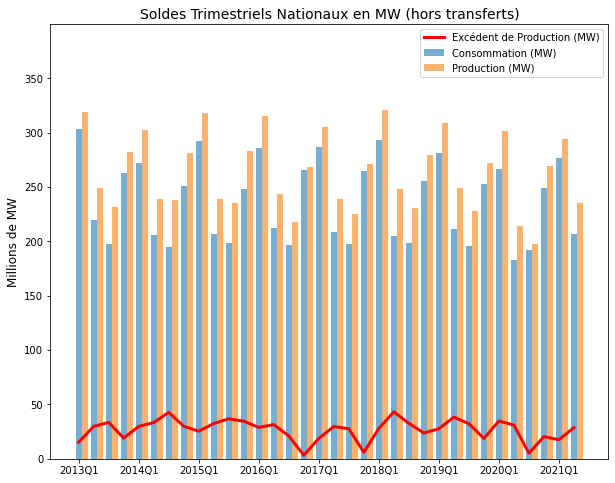

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

temp_df = df.groupby(['Trimestre']).sum().reset_index()
barwidth=0.4
x1 = np.arange(0,(len(temp_df)),1)
x2 = x1 + barwidth

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)
ax1.bar(x1, temp_df['Consommation (MW)'], label = 'Consommation (MW)', width = barwidth, alpha=0.6)
ax1.bar(x2, temp_df['Consommation (MW)'] + temp_df['Solde brut (MW)'], 
        label = 'Production (MW)', width = barwidth, alpha=0.6)
ax1.plot(x1, temp_df['Solde brut (MW)'], 'r-', linewidth = 3, label = 'Excédent de Production (MW)')

ax1.set_title('Soldes Trimestriels Nationaux en MW (hors transferts)', fontsize=14)
ax1.set_xticks(np.arange(0,(len(temp_df)),4))
ax1.set_xticklabels(temp_df['Trimestre'][::4])

ax1.set_ylim([0,400000000])
ax1.set_yticks(np.arange(0,400000000,50000000))
ax1.set_yticklabels([0,50,100,150,200,250,300,350])
ax1.set_ylabel('Millions de MW', fontsize=12)

ax1.legend()
plt.show();

In [12]:
import statsmodels.api

#Test ANOVA
temp_df['Trimestre'] = temp_df['Trimestre'].str[-1:]
temp_df.rename(columns={"Solde brut (MW)": "Solde"}, inplace=True)
result = statsmodels.formula.api.ols('Solde ~ Trimestre', data = temp_df).fit()  
table = statsmodels.api.stats.anova_lm(result)

print('Test ANOVA')
print(table)

Test ANOVA
             df              sum_sq            mean_sq    F  PR(>F)
Trimestre  3.00  855190461209777.00 285063487069925.69 3.81    0.02
Residual  30.00 2247324147505122.50  74910804916837.42  NaN     NaN


<h2> Interprétation </h2>
La France est depuis 2013 excédentaire dans sa capacité de production électrique. Cependant, on peut voir certains trimestres en tension comme les derniers trimestres 2016 ou 2017. Avec le test ci-dessus, il apparaît clairement que le solde de production est fortement dépendant du trimestre de l'année (la p-value étant inférieure au seuil de 5%)

**Graph N°2: évolution mensuelle**

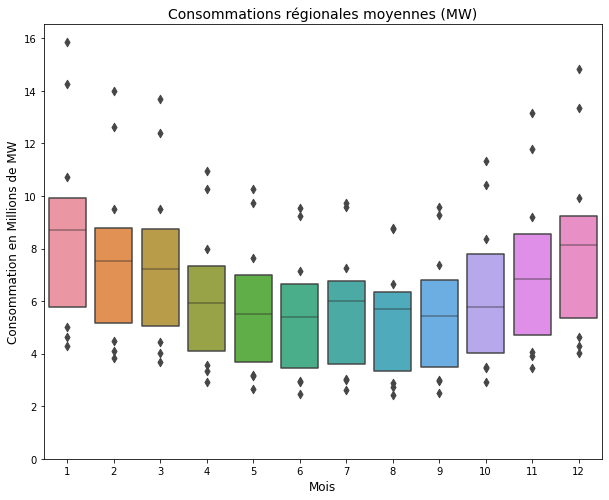

In [13]:
temp_df = df.groupby(['Région', 'Année', 'Mois']).sum().reset_index()
temp_df = temp_df.groupby(['Région', 'Mois']).mean().reset_index()

fig = plt.figure(figsize=(10,8))
ax2 = fig.add_subplot(111)
sns.boxenplot(x='Mois', y='Consommation (MW)', data=temp_df, ax=ax2) #showfliers=False

ax2.set_title('Consommations régionales moyennes (MW)', fontsize=14)
ax2.set_yticks(np.arange(0,18000000,2000000))
ax2.set_yticklabels([0,2,4,6,8,10,12,14,16])
ax2.set_ylabel('Consommation en Millions de MW', fontsize=12)
ax2.set_xlabel('Mois', fontsize=12)

plt.show();

In [14]:
#Données chiffrées nationales
temp_df = df.groupby(['Région', 'Année', 'Mois']).sum().reset_index()
temp_df.groupby(['Mois']).agg({'Consommation (MW)': ['median', 'mean', 'min', 'max']})

Consommation (MW)                                  
                median       mean        min         max
Mois                                                    
1           8639452.50 8624885.11 3927224.00 17785746.00
2           7409691.00 7616059.89 3554354.00 15613449.00
3           7093898.00 7462286.65 3454522.00 15582496.00
4           5812686.50 6108992.33 2525197.00 12457808.00
5           5443718.00 5705922.57 2430012.00 11149587.00
6           5329830.50 5392432.41 2310532.00  9986972.00
7           6059584.00 5656357.88 2477809.00 10145846.00
8           5721442.50 5247356.12 2326177.00  9104205.00
9           5400531.00 5466990.44 2441994.00  9952434.00
10          5735013.00 6196592.26 2785258.00 12100592.00
11          6914893.50 7119804.45 3159962.00 14152841.00
12          8173721.50 8050724.95 3540602.00 15809878.00

In [15]:
#Test ANOVA
temp_df.rename(columns={"Consommation (MW)": "Consommation"}, inplace=True)
result = statsmodels.formula.api.ols('Consommation ~ Mois', data = temp_df).fit()  
table = statsmodels.api.stats.anova_lm(result)

print('Test ANOVA')
print(table)

Test ANOVA
              df               sum_sq            mean_sq     F  PR(>F)
Mois        1.00   124069519053615.25 124069519053615.25 13.81    0.00
Residual 1222.00 10978673482968658.00   8984184519614.29   NaN     NaN


In [16]:
pd.reset_option('display.float_format')

<h2> Interprétation</h2>
Il y a une claire saisonnalité de la consommation électrique qui est à son pic en hiver et à son minimum en été (test de la p-value inférieur à 5%). Cependant, on peut remarquer une grande disparité dans la consommation entre les régions grâce au boxenplot.

**Graph N°3: anomalies**

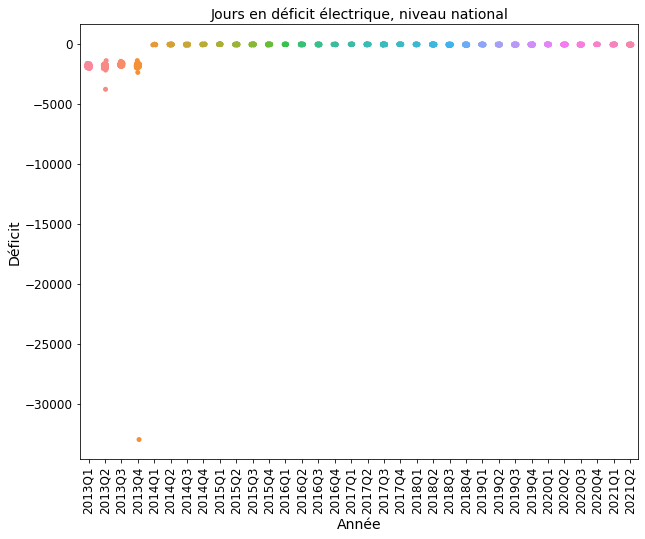

In [17]:
temp_df = df.groupby(['Date']).sum().reset_index() #'Date - Heure', 
temp_df = temp_df[temp_df['Solde avec transferts (MW)']< 0]

fig = plt.figure(figsize=(10,8))
ax3 = fig.add_subplot(111)
sns.stripplot(x = pd.PeriodIndex(temp_df['Date'], freq='Q'), y = 'Solde avec transferts (MW)',data=temp_df, ax=ax3)

ax3.set_title('Jours en déficit électrique, niveau national', fontsize=14)
ax3.set_xlabel('Année', fontsize=14)
ax3.set_ylabel('Déficit', fontsize=14)
ax3.tick_params(labelsize=12)
plt.xticks(rotation='vertical')
plt.show();

<h2> Interprétation</h2>
Les données 2013 indiquent un grand nombre de jours avec des déficits en électricité. La récurrence sur cette période et sa disparition par la suite mettent un doute sur la qualité de certaines données en 2013. Il faut se rappeler que les pompages et échanges physiques sont pris en compte. Ci-dessous, on a 2 jours aux soldes extrêmes en décembre 2013.

In [18]:
#Jour en décembre en 2013 avec un solde négatif extrêmement important
temp_df[temp_df['Solde avec transferts (MW)'] < -5000]

,Date,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Hydraulique (MW),Pompage (MW),Bioénergies (MW),Ech. physiques (MW),TCO Thermique (%),TCO Nucléaire (%),TCO Eolien (%),TCO Solaire (%),TCO Hydraulique (%),TCO Bioénergies (%),Renouvelables (MW),Solde brut (MW),Solde avec transferts (MW),Taux Couverture (MW),Taux Couverture Renouvelables (MW),Weekday,Jour,Mois,Année
360,2013-12-27,2943598.0,116496.0,2518081.0,217532.0,12884.0,348748.0,-81666.0,37325.0,-258796.0,0.0,0.0,0.0,0.0,0.0,0.0,534823.0,225802.0,-32994.0,671.576596,97.124443,2304,15552,6912,1159488


In [19]:
#Jour en décembre en 2013 avec un solde positif extrêmement important. Possible compensation du chiffre négatif ci-dessus
temp_df = df.groupby(['Date']).sum().reset_index() #'Date - Heure', 
temp_df[temp_df['Solde avec transferts (MW)']> 5000]

,Date,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Hydraulique (MW),Pompage (MW),Bioénergies (MW),Ech. physiques (MW),TCO Thermique (%),TCO Nucléaire (%),TCO Eolien (%),TCO Solaire (%),TCO Hydraulique (%),TCO Bioénergies (%),Renouvelables (MW),Solde brut (MW),Solde avec transferts (MW),Taux Couverture (MW),Taux Couverture Renouvelables (MW),Weekday,Jour,Mois,Année
334,2013-12-01,3056545.0,318385.0,2557468.0,115711.0,16796.0,302485.0,-71385.0,37885.0,-191547.0,0.0,0.0,0.0,0.0,0.0,0.0,401492.0,220800.0,29253.0,683.518566,76.073054,3456,576,6912,1159488


**Graph N°4: renouvelables**

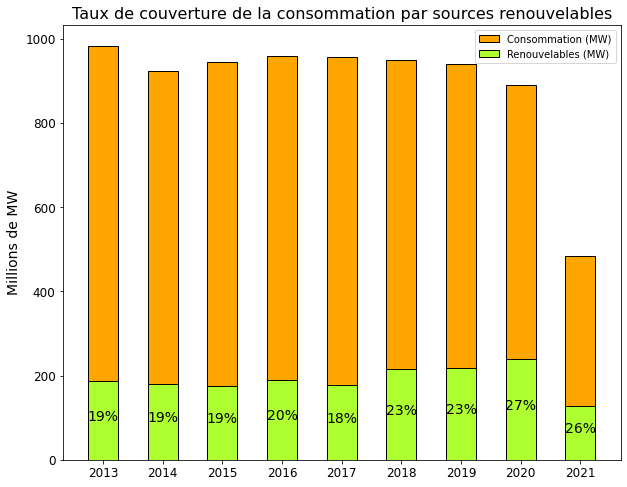

In [20]:
temp_df = df.groupby(['Année']).sum().reset_index()
temp_df['Autre_conso'] = temp_df['Consommation (MW)'] - temp_df['Renouvelables (MW)']
temp_df['Percentage'] = temp_df['Renouvelables (MW)'] / temp_df['Consommation (MW)']
barwidth=0.5

fig = plt.figure(figsize=(10,8))
ax4 = fig.add_subplot(111)
ax4.bar(x=temp_df['Année'], height=temp_df['Autre_conso'], bottom = temp_df['Renouvelables (MW)'], 
        label = 'Consommation (MW)', width = barwidth, color='orange', edgecolor='black')
graph = ax4.bar(x=temp_df['Année'], height=temp_df['Renouvelables (MW)'], 
                label = 'Renouvelables (MW)', width = barwidth, color='greenyellow', edgecolor='black')

ax4.set_title('Taux de couverture de la consommation par sources renouvelables', fontsize=16)
ax4.tick_params(labelsize=12)
ax4.set_xticks(temp_df['Année'])
ax4.set_xticklabels(temp_df['Année'])

ax4.set_yticks(np.arange(0,1100000000,200000000))
ax4.set_yticklabels([0,200,400,600,800,1000])
ax4.set_ylabel('Millions de MW', fontsize=14)

#Création des labels pourcentage
i=0
for p in graph:
        percentage = "{:.0f}".format(round(temp_df.loc[i,'Percentage']*100, 0))
        x = p.get_x() + p.get_width()/2
        y = p.get_y() + p.get_height()/2
        ax4.text(x=x, y=y, s = f'{percentage}%', ha='center', color='black', size=14)
        i += 1

ax4.legend()
plt.show();

<h2> Interprétation</h2> 
La couverture de la consommation par les sources renouvables a augmenté sensiblement à partir de 2018 et se stabilise maintenant aux alentours des 27%.

**Graph N°5: focus sur le solaire et l'éolien**

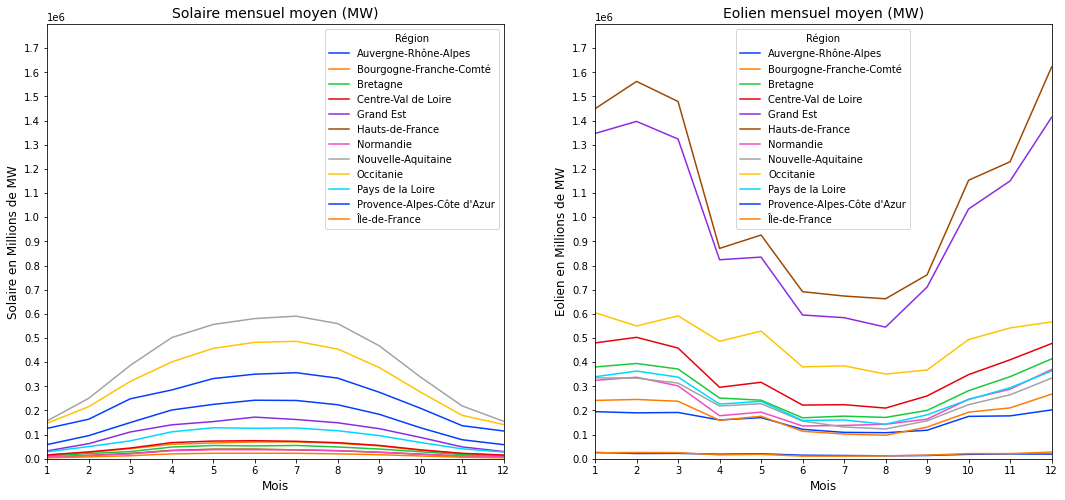

In [21]:
temp_df = df.groupby(['Région', 'Année', 'Mois']).sum().reset_index()
temp_df = temp_df.groupby(['Région', 'Mois']).mean().reset_index()

fig = plt.figure(figsize=(18,8))
ax6 = fig.add_subplot(121)
ax7 = fig.add_subplot(122, sharex = ax6, sharey = ax6)
sns.lineplot(x='Mois', y='Solaire (MW)', hue='Région', palette = 'bright', data=temp_df, ax=ax6)
sns.lineplot(x='Mois', y='Eolien (MW)', hue='Région', palette = 'bright', data=temp_df, ax=ax7)

ax6.set_title('Solaire mensuel moyen (MW)', fontsize=14)
ax7.set_title('Eolien mensuel moyen (MW)', fontsize=14)
ax6.set_yticks(np.arange(0,1800000,100000))
ax6.set_ylabel('Solaire en Millions de MW', fontsize=12)
ax7.set_ylabel('Eolien en Millions de MW', fontsize=12)
ax6.set_xlabel('Mois', fontsize=12)
ax7.set_xlabel('Mois', fontsize=12)
ax6.set_xlim([1,12])
ax6.set_ylim([0,1800000])
ax6.set_xticks(np.arange(1,13))
ax6.set_xlabel('Mois', fontsize=12)
plt.show();

In [22]:
#Test ANOVA
temp_df.rename(columns={"Solaire (MW)": "Solaire"}, inplace=True)
result = statsmodels.formula.api.ols('Solaire ~ Mois', data = temp_df).fit()  
table = statsmodels.api.stats.anova_lm(result)

print('Test ANOVA Solaire')
print(table)

Test ANOVA Solaire
             df        sum_sq       mean_sq         F    PR(>F)
Mois        1.0  2.367429e+09  2.367429e+09  0.114168  0.735947
Residual  142.0  2.944564e+12  2.073637e+10       NaN       NaN


In [23]:
#Test ANOVA
temp_df.rename(columns={"Eolien (MW)": "Eolien"}, inplace=True)
result = statsmodels.formula.api.ols('Eolien ~ Mois', data = temp_df).fit()  
table = statsmodels.api.stats.anova_lm(result)

print('Test ANOVA Eolien')
print(table)

Test ANOVA Eolien
             df        sum_sq       mean_sq         F    PR(>F)
Mois        1.0  6.326570e+10  6.326570e+10  0.479229  0.489902
Residual  142.0  1.874622e+13  1.320157e+11       NaN       NaN


<h2> Interprétation</h2>
On voit un lien entre la saisonnalité et les productions d'énergie solaires et éoliennes (solaire en été, éolien en hiver). Cependant, les tests des p-value ne sont pas concluants avec des p-values extrêmement élevées.

**Graph N°6 solde régional**

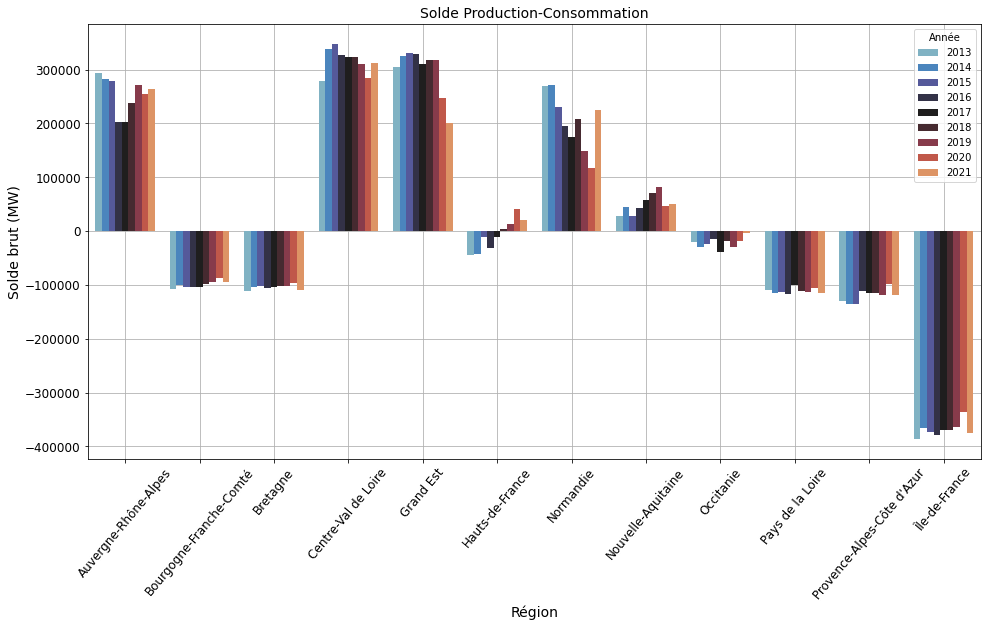

In [24]:
temp_df = df.groupby(['Région', 'Date', 'Année']).sum().reset_index()
temp_df = temp_df.groupby(['Région', 'Année']).mean().reset_index()

barwidth=0.5

fig = plt.figure(figsize=(16,8))
ax5 = fig.add_subplot(111)
sns.barplot(x='Région', y='Solde brut (MW)', hue='Année', data=temp_df, palette = "icefire", ax=ax5)

ax5.set_title('Solde Production-Consommation', fontsize=14)
ax5.set_xlabel('Région', fontsize=14)
ax5.set_ylabel('Solde brut (MW)', fontsize=14)
ax5.tick_params(labelsize=12)
plt.xticks(rotation=50)
ax5.set_axisbelow(True)
plt.grid('both')
plt.show();

In [25]:
#Test ANOVA
temp_df.rename(columns={"Solde brut (MW)": "Solde"}, inplace=True)
result = statsmodels.formula.api.ols('Solde ~ Région', data = temp_df).fit()  
table = statsmodels.api.stats.anova_lm(result)

print('Test ANOVA')
print(table)

Test ANOVA
            df        sum_sq       mean_sq           F        PR(>F)
Région    11.0  4.275360e+12  3.886691e+11  580.751464  1.276866e-82
Residual  96.0  6.424820e+10  6.692521e+08         NaN           NaN


<h2> Interprétation</h2>
La situation des régions reste globalement stable, avec certaines clairement excédentaires et d'autres en demande d'électricité. On remarque cependant que le Grand-Est est dernièrement moins excédentaire tandis que la Normandie a amélioré sa situation. Naturellement, la p-value du test effectué ci-dessus confirme la relation entre la région et le solde électrique (p-value inférieure à 5%)

**Graph N°7: mix énergétique**

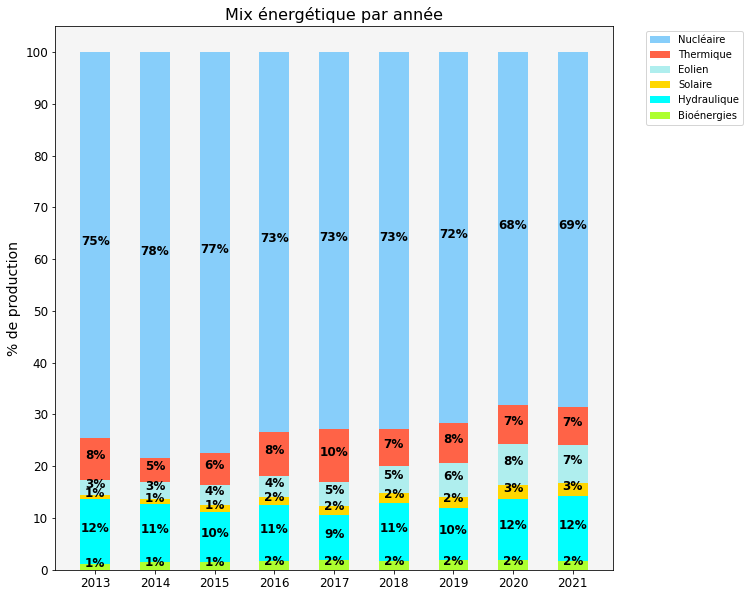

In [26]:
temp_df = df.groupby(['Année']).sum().reset_index()
temp_df['Production'] = temp_df['Thermique (MW)'] + temp_df['Nucléaire (MW)'] + temp_df['Renouvelables (MW)']
temp_df['Thermique'] = temp_df['Thermique (MW)'] / temp_df['Production']
temp_df['Nucléaire'] = temp_df['Nucléaire (MW)'] / temp_df['Production']
temp_df['Eolien'] = temp_df['Eolien (MW)'] / temp_df['Production']
temp_df['Solaire'] = temp_df['Solaire (MW)'] / temp_df['Production']
temp_df['Bioénergies'] = temp_df['Bioénergies (MW)'] / temp_df['Production']
temp_df['Hydraulique'] = (temp_df['Hydraulique (MW)'] + temp_df['Pompage (MW)']) / temp_df['Production']
barwidth=0.5

fig = plt.figure(figsize=(10,10))
ax4 = fig.add_subplot(111)
graph1 = ax4.bar(x=temp_df['Année'], height=temp_df['Nucléaire'], bottom = temp_df['Thermique'] + temp_df['Eolien'] + temp_df['Solaire'] + temp_df['Bioénergies'] + temp_df['Hydraulique'], 
                 label = 'Nucléaire', width = barwidth, color='lightskyblue')
graph2 = ax4.bar(x=temp_df['Année'], height=temp_df['Thermique'], bottom = temp_df['Eolien'] + temp_df['Solaire'] + temp_df['Bioénergies'] + temp_df['Hydraulique'], 
                 label = 'Thermique', width = barwidth, color='tomato')
graph3 = ax4.bar(x=temp_df['Année'], height=temp_df['Eolien'], bottom = temp_df['Solaire'] + temp_df['Bioénergies'] + temp_df['Hydraulique'], 
                 label = 'Eolien', width = barwidth, color='paleturquoise')
graph4 = ax4.bar(x=temp_df['Année'], height=temp_df['Solaire'], bottom = temp_df['Bioénergies'] + temp_df['Hydraulique'], 
                 label = 'Solaire', width = barwidth, color='gold')
graph5 = ax4.bar(x=temp_df['Année'], height=temp_df['Hydraulique'], bottom = temp_df['Bioénergies'], 
                 label = 'Hydraulique', width = barwidth, color='aqua')
graph6 = ax4.bar(x=temp_df['Année'], height=temp_df['Bioénergies'], 
                label = 'Bioénergies', width = barwidth, color='greenyellow')

ax4.set_facecolor('whitesmoke')
ax4.set_title('Mix énergétique par année', fontsize=16)
ax4.tick_params(labelsize=12)
ax4.set_xticks(temp_df['Année'])
ax4.set_xticklabels(temp_df['Année'])
ax1.set_ylim([0,1])
ax4.set_yticks(np.arange(0,1.1,0.1))
ax4.set_yticklabels([0,10,20,30,40,50,60,70,80,90,100])
ax4.set_ylabel('% de production', fontsize=14)

#mise en place des pourcentages dans le graphique
graph_list = [graph1, graph2, graph3, graph4, graph5, graph6]
label_list = ['Nucléaire', 'Thermique', 'Eolien', 'Solaire', 'Hydraulique', 'Bioénergies']
for count, item in enumerate(graph_list):
    i=0
    for p in item:
        label = label_list[count]
        percentage = "{:.0f}".format(round(temp_df.loc[i,label]*100, 0))
        x = p.get_x() + p.get_width()/2
        y = p.get_y() + p.get_height()/2
        ax4.text(x=x, y=y, s = f'{percentage}%', ha='center', color='black', weight='bold', size=12)
        i += 1

ax4.legend(bbox_to_anchor=(1.05, 1))
plt.show();

<h2> Interprétation</h2>
Nous remarquons une substitution progressive du nucléaire par des sources renouvelables (l'éolien et le solaire montant en puissance). Cependant, le nucléaire reste de loin la principale source électrique française.

**Graph N°8 : Évolution de la consommation moyenne en MW, par type d'énergie, par an et par région.**


In [27]:
def graph(type):
  from bokeh.plotting import figure
  from bokeh.models import CheckboxGroup, CustomJS, Button
  from bokeh.layouts import row, column
  import random
  color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(12)]
  x = df['Année'].unique().tolist()
  regions = df['Région'].unique().tolist()
  p = figure(plot_width = 700, plot_height = 350, title = "Consommation moyenne en MW, par type d'énergie, par an et par région.") 
  p.xaxis.ticker = x
  checkbox_group = CheckboxGroup(labels=regions, active=list(range(len(regions))))
  select_all = Button(label='SÉLECTIONNER TOUT')
  select_none = Button(label='DÉSÉLECTIONNER TOUT')
  args = [('checkbox', checkbox_group)]
  code = "var active = cb_obj.active;"
  for c in range(len(regions)):
    y = (df[df['Région']==regions[c]]).groupby(['Année']).agg({type: 'mean'})[type]
    line = p.line(x=x, y = y, line_width=2, color = color[c],  alpha=1, legend_label=regions[c])
    args += [('line'+str(c), line)]
    code += "line{}.visible = active.includes({});".format(c, c)
  checkbox_group.js_on_change('active', CustomJS(args={key:value for key,value in args}, code=code))
  select_all.js_on_click(CustomJS(args={'checkbox_group': checkbox_group, 'regions': regions}, 
                                  code="checkbox_group.active = Array.from(regions, (x, i) => i);"))
  select_none.js_on_click(CustomJS(args={'checkbox_group': checkbox_group}, code="checkbox_group.active = [];"))
  group = column(select_all, select_none, checkbox_group)
  p.add_layout(p.legend[0], 'right')
  return row(group, p)
from bokeh.models.widgets import Panel, Tabs  
from bokeh.plotting import output_notebook, show
output_notebook()
titles = ['TOUS-LES-TYPES','THERMIQUE','NUCLEAIRE','EOLIEN','SOLAIRE','HYDRAULIQUE', 'BIOENERGIE']
types = ['Consommation (MW)','Thermique (MW)','Nucléaire (MW)','Eolien (MW)','Solaire (MW)','Hydraulique (MW)', 'Bioénergies (MW)']
tab = []
for i in range(7):
  tab.append(Panel(child = graph(types[i]), title = titles[i]))
show(Tabs(tabs = tab))


Loading BokehJS ...

<h2> Présentation du graphique et commentaires </h2>
Sur cette représentation graphique, nous étudions l’évolution dans le temps de la consommation totale moyenne et de la consommation marginale de chaque type d’énergie et pour chaque région. 

**Consommation totale par région**

Pour ce qui concerne la consommation totale, les courbes des variations sont quasiment parallèles pour les différentes régions malgré les ordres de grandeurs différents. Cela suggère une corrélation entre les consommations des différentes régions. Nous savons que le niveau de consommation est fonction des évolutions socio-économiques (densité de la population, développement industriel, agriculture, transports, etc.). Nous pouvons dire que ces différents facteurs n’influencent pas tellement la répartition (en termes de proportions) des consommations énergétiques par région. Concernant les quantités d’énergie consommée, les régions du Centre-Val de Loire, Bourgogne-Franche-Comté et Bretagne sont les moins consommatrices alors que l’Île-de-France et l’Auvergne-Rhône-Alpes sont de loin, les plus consommatrices. 

**Consommation par région et par type d'énergie**

Pour ce qui concerne les types d’énergie, l’énergie nucléaire reste la plus consommée même si le niveau de consommation connait une légère baisse en faveur des autres types d’énergie. L’Auvergne-Rhône-Alpes et le Grand Est restent les régions qui consomment plus l’énergie nucléaire. Cependant, la consommation du Grand Est connait une baisse drastique depuis 2018 au profit de la Normandie.  L’Île-de-France, le Pays de la Loire, Provence-Alpes-Côte d'Azur et la Bretagne ne consomment pas du tout l’énergie nucléaire. Les niveaux de consommation des énergies éoliennes et solaires ont beaucoup progressé même si relativement à la quantité totale d’énergie consommée, cela n’est pas vraiment représentatif. Le niveau de consommation de l’énergie hydraulique stagne alors que la consommation des bioénergies baisse légèrement depuis 2018. 


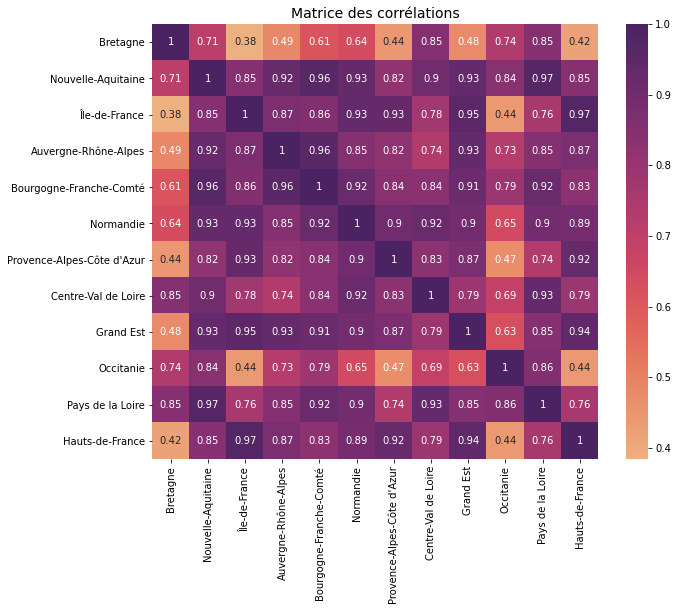

In [28]:
#Etude de la corrélation entre les consommations des régions.  
import pandas as pd
regions = df['Région'].unique().tolist()
df_co =pd.DataFrame({})
for c in range(len(regions)):
  df_co[regions[c]]= pd.Series((df[df['Région']==regions[c]]).groupby(['Année'], as_index=False).agg({'Consommation (MW)': 'mean'})['Consommation (MW)'])
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
sns.heatmap(df_co.corr(), annot=True, cmap='flare', ax=ax)
ax.set_title('Matrice des corrélations', fontsize=14)
plt.show();

<h2> Interprétation</h2>
On note effectivement une forte corrélation entre les consommations de plusieurs régions.  

**Graph N°9 : Évolution de la consommation en MW, par mois et par an.**

In [29]:
def conso(mois):
  from bokeh.plotting import figure
  from bokeh.models import CheckboxGroup, CustomJS, Button
  from bokeh.layouts import row, column
  import random
  color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(12)]
  ans = df['Année'].unique().tolist()
  ans = ans[:len(ans)-1]
  annees = [str(i) for i in ans]
  p = figure(plot_width = 700, plot_height = 350, title = "Consommation en MW, par mois et par an.") 
  x = df[df['Mois']== mois]['Jour'].unique().tolist()
  x = x[:28]
  p.xaxis.ticker = x
  checkbox_group = CheckboxGroup(labels= ['Année '+str(i) for i in ans], active=list(range(len(annees))))
  select_all = Button(label='SÉLECTIONNER TOUT')
  select_none = Button(label='DÉSÉLECTIONNER TOUT')
  args = [('checkbox', checkbox_group)]
  code = "var active = cb_obj.active;"
  for c in range(len(annees)):
    y = (df[(df['Année']== int(annees[c])) & (df['Mois']==mois)]).groupby(['Jour']).agg({'Consommation (MW)': 
                                                                                         'mean'})['Consommation (MW)']
    y=y[0:28]
    line = p.line(x=x, y = y, line_width=2, color = color[c],  alpha=1, legend_label='Année '+annees[c])
    args += [('line'+str(c), line)]
    code += "line{}.visible = active.includes({});".format(c, c)
  checkbox_group.js_on_change('active', CustomJS(args={key:value for key,value in args}, code=code))
  select_all.js_on_click(CustomJS(args={'checkbox_group': checkbox_group, 'annees': annees}, 
                                  code="checkbox_group.active = Array.from(annees, (x, i) => i);"))
  select_none.js_on_click(CustomJS(args={'checkbox_group': checkbox_group}, code="checkbox_group.active = [];"))
  group = column(select_all, select_none, checkbox_group)
  p.add_layout(p.legend[0], 'right')
  return row(group, p)
from bokeh.models.widgets import Panel, Tabs  
from bokeh.plotting import output_notebook, show
output_notebook()
titles = ['JANVIER','FEVRIER','MARS','AVRIL','MAI','JUIN', 'JUILLET', 'AOUT', 'SEPTEMBRE','OCTOBRE','NOVEMBRE','DECEMBRE']
tab = []
for i in range(12):
  tab.append(Panel(child = conso(i+1), title = titles[i]))
show(Tabs(tabs = tab))

Loading BokehJS ...

<h2> Présentation du graphique et commentaires </h2>
Sur ce graphique, nous étudions les variations de la consommation par mois et par an. On peut constater que les différentes courbes se chevauchent. Cela montrent que d’une année à l’autre, une même période de l’année n’induit pas nécessairement le même niveau de consommation. L'année 2021 n'étant pas encore achevée, nous avons choisir de l'écarter pour cette représentation. 

<h3> Hypothèses sur les variations observées </h3>

<h4>Changement des conditions climatiques</h4>

Les variations observées peuvent se justifier par les changements des conditions climatiques notamment la température. En effet, plus il fait froid, plus les consommateurs utilisent les chauffages qui sont en bonne partie, électriques.  Inversement, s’il fait trop chaud, les consommateurs vont utiliser la climatisation ou les ventilateurs qui sont également source de consommation électrique. 

La validité de cette hypothèse peut être étudiée à partir des rélévés de température. Quelques éléments graphiques offrent un début de validation de l'hypothèse. En effet, les plus grandes variations sont observées en hiver avec notamment un pic obtenu en fin février 2018 pour une consommation qui avoisine les 7500 MW. 

<h4>Variation des dates qui correspondent aux week-ends</h4>

Une autre hypothèse sur les variations observées, porte sur les changements qu’on observe d’une année à l’autre au niveau des dates du mois qui correspondent aux week-ends. En effet, nous savons que la consommation est plus faible les week-ends. Ainsi, si le 1 mars d’une année est un dimanche, on aura une faible consommation mais pour l’année qui suit, le 1 mars sera un lundi avec une plus grande consommation. 

<h3>Quelques cas spécifiques</h3>

De spécifique, nous pouvons noter que chaque année, la consommation est très basse les jours de certains événements tels que le : le 14 juillet (Fête nationale), 15 aout (Assomption), 11 novembre (Armistice 1918), 25 décembre (Noël), etc. A noter que tous les jours fériés ne présentent pas cette même tendance.  C’est parce que certains événements sont plus populaires que d’autres.

<h3>Périodes de confinement</h3>

L’année 2020 a été marquée par la pandémie de covid-19 qui a donné lieu à plusieurs périodes de confinements. Sur le graphique, on peut constater la chute historique de la consommation à partir de mi-mars, date de début du premier confinement. Le mois d’avril 2020 sera le mois qui présente les plus basses consommations depuis 2013. Durant le second confinement notamment au mois d’octobre 2020, on observe également une baisse de la consommation. Ces baisses observées pendant les périodes de confinement se justifient par l’arrêt de de la plupart des activités. 


**Graph N°10 : Évolution de la consommation moyenne en MW, par région, par type d'énergie et par an.**

In [30]:
from bokeh.models.widgets import Panel 
from bokeh.models.widgets import Tabs  
from bokeh.plotting import figure
regions = df['Région'].unique().tolist()
tab = []
p=[]
x4 = df['Année'].unique().tolist() 
x1 = [int(i)-0.3 for i in x4]      
x2 = [int(i)-0.2 for i in x4]      
x3 = [int(i)-0.1 for i in x4]      
x5 = [int(i)+0.1 for i in x4]      
x6 = [int(i)+0.2 for i in x4]      
x7 = [int(i)+0.3 for i in x4]      
top = [1, 2, 3, 4, 5, 6, 7, 8, 9]
top1 = [int(i)-1 for i in top]
width = 0.1
for i in range(len(regions)):
  p.append(figure(plot_width = 1100, plot_height = 400, title = regions[i]+ " : consommation moyenne en MW, par type d'énergie et par an."))
  p[i].vbar(x=x2, top = df[df['Région']==regions[i]].groupby(['Année']).agg({'Thermique (MW)': 'mean'})['Thermique (MW)'], color = 'red', legend_label="Thermique (MW)", width = width)
  p[i].vbar(x=x3, top = df[df['Région']==regions[i]].groupby(['Année']).agg({'Nucléaire (MW)': 'mean'})['Nucléaire (MW)'], color = 'indigo', legend_label="Nucléaire (MW)", width = width)
  p[i].vbar(x=x4, top = df[df['Région']==regions[i]].groupby(['Année']).agg({'Eolien (MW)': 'mean'})['Eolien (MW)'], color = 'plum', legend_label="Eolien (MW)", width = width)
  p[i].vbar(x=x5, top = df[df['Région']==regions[i]].groupby(['Année']).agg({'Solaire (MW)': 'mean'})['Solaire (MW)'], color = 'orange', legend_label="Solaire (MW)", width = width)
  p[i].vbar(x=x6, top = df[df['Région']==regions[i]].groupby(['Année']).agg({'Hydraulique (MW)': 'mean'})['Hydraulique (MW)'], color = 'lime', legend_label="Hydraulique (MW)", width = width)
  p[i].vbar(x=x7, top = df[df['Région']==regions[i]].groupby(['Année']).agg({'Bioénergies (MW)': 'mean'})['Bioénergies (MW)'], color = 'green', legend_label="Bioénergies (MW)", width = width)
  p[i].xaxis.ticker = x4
  p[i].add_layout(p[i].legend[0], 'right')
  tab.append(Panel(child = p[i], title = regions[i][:11]))
show(Tabs(tabs = tab))

<h2> Présentation du graphique et commentaires </h2>
Ce graphique montre pour chaque région, une évolution comparative des consommations énergétiques pour les différents types d’énergie. Malgré des variations plus ou moins sensibles, nous constatons que chaque région est marquée par un certain nombre de type d’énergie dont les ordres de grandeur des quantités consommées restent assez constants. 

Par exemple, la Bretagne consomme dans l’ordre des quantités décroissantes : l’énergie éolienne, l’énergie thermique, l’énergie hydraulique, la bioénergie, l’énergie solaire. Cet ordre de grandeur est constant depuis 2013. 

Pour les autres régions, on a d’autres classements qui sont tout aussi constants dans le temps. Pour les régions qui consomment majoritairement les énergies renouvelables, cela est une bonne chose. Pour les régions qui consomment l’énergie nucléaire, la situation est préoccupante car l’idéal c’est d’inverser le classement. 

A travers ce graphique, nous pouvons déduire le niveau d’accessibilité des régions aux différentes sources d’énergie. En supposant que chaque région consomme les énergies les plus accessibles. Cette hypothèse est tout à fait logique car le transport d’énergie est un enjeu majeur. 

**Quelques hypothèses de base à ce stade et corrélations entre variables**

La France est en permanence avec une capacité de production excédentaire et ajuste sa production à sa consommation. La probabilité de blackout est en fait assez faible.

Le mix énergétique quant à lui peut évoluer et dépend des saisons, mois mais évolue aussi au fil des années.

La consommation a pu être impactée dans une certaine mesure par la pandémie en 2020 et 2021.

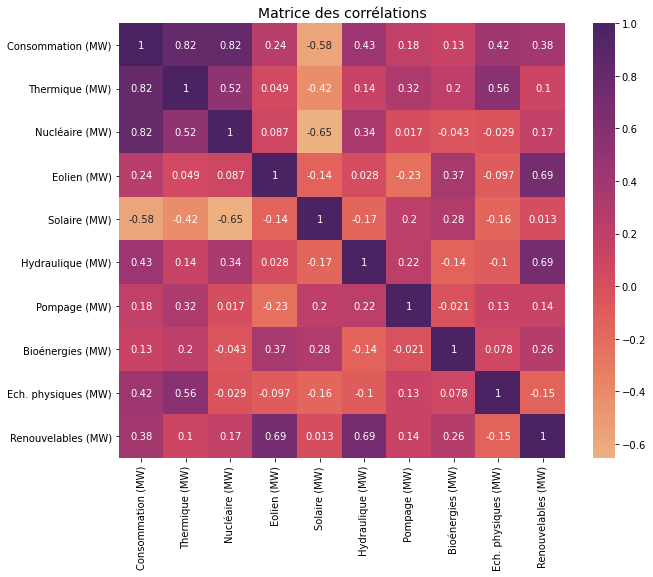

In [31]:
temp_df = df.groupby(['Date']).sum().reset_index()
float_list = ['Consommation (MW)', 'Thermique (MW)', 'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)', 
              'Hydraulique (MW)', 'Pompage (MW)', 'Bioénergies (MW)', 'Ech. physiques (MW)', 'Renouvelables (MW)']
corrmap = temp_df[float_list].corr()

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
sns.heatmap(corrmap, annot=True, cmap='flare', ax=ax)

ax.set_title('Matrice des corrélations', fontsize=14)
plt.show();

On peut remarquer quelques corrélations intéressantes sur ce tableau des corrélations (à l'échelle nationale, ce qui élimine la variable "régions"):
- le solaire est corrélé négativement à la consommation car produit essentiellement en été, période où la consommation est la plus faible
- les échanges physiques sont corrélés assez significativement avec la production thermique et la consommation, ce qui pourrait vouloir dire que la France utiliserait sa production thermique lorsque le solde des transferts vers l'étranger est plus faible (et que la consommation nationale est importante)